In [ ]:
import torch
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import ImageColor, ImageFont, Image, ImageDraw

In [ ]:
def res_to_list(results, frame_num, res_list=[]):
    """convert the detection results to a list"""
    frame_res = results.xyxyn[0].numpy()
    obj_count = frame_res.shape[0]

    for j in range(obj_count):
        line = [frame_num, j+1] + frame_res[j].tolist()
        res_list.append(line)
    return res_list

In [ ]:
def draw_results(image, results, relevant_class_id =[2]):
  """Draw the detection results on a copy of the source image"""

  colors = list(ImageColor.colormap.values())
  new_image = image.copy()
  font = ImageFont.load_default()

  for i in range(len(results.xyxy[0])):
    det_line = results.xyxyn[0].numpy()[i]
    boxes = det_line[:4]
    score = det_line[4]
    class_id = det_line[5]
    class_name = results.names[class_id]

    if class_id in relevant_class_id:
      xmin, ymin, xmax, ymax  = boxes

      display_str = "{}: {}%".format(class_name,
                                      int(100 * score))
      
      color = colors[hash(class_name) % len(colors)]
      image_pil = Image.fromarray(np.uint8(new_image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(new_image, np.array(image_pil))
  return new_image

In [ ]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=2,
                               display_str_list=()):
  
  """Adds a bounding box and class name text box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]

  # top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height

  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    
    text_bottom -= text_height - 2 * margin

In [ ]:
# model_version = 'yolov5s' # small version
model_version = 'yolov5m'

model = torch.hub.load('ultralytics/yolov5', model_version, pretrained=True)

model.conf = 0.73  # confidence threshold
# model.iou = 0.25  # NMS IoU threshold (0-1)  

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-11-21 Python-3.7.15 torch-1.12.1+cu113 CPU

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
# torch.save(model.state_dict(), 'model_weights.pth')
# torch.save(model, 'model.pth')
# torch.save('model_yolov5.pth')
# model2 = torch.load('model.pth')

In [ ]:
PATH = '/content/fpv-drone-vs-rallycross-cars.mp4'

cap = cv2.VideoCapture(PATH)

H = 360
W = 640
fps = 20

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('output.mp4', fourcc, fps, (W,H))
result_list = []
while True:
# for i in range(0,600,20):
    ret, original_frame = cap.read()
    if ret==True:
        frame = cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB)
        # get detection results
        results = model(frame)

        result_list = res_to_list(results, i, result_list)
        # draw results on image 
        image_with_boxes = draw_results(frame, results)

        # write the output frame
        image_with_boxes = cv2.cvtColor(image_with_boxes, cv2.COLOR_RGB2BGR)
        out.write(image_with_boxes)

    else:
        break

# Release everything if job is finished
cap.release()
out.release()


In [ ]:
col_list = ['frame', 'object', 'xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class']
df = pd.DataFrame(result_list, columns = col_list)

df.to_json('df2.json', orient="index", indent=2) 

df.head()

,frame,object,xmin,ymin,xmax,ymax,confidence,class
0,0,1,0.138193,0.263083,0.492422,0.757033,0.914366,2.0
1,0,2,0.527747,0.241847,0.819770,0.495380,0.907199,2.0
2,0,3,0.455543,0.194287,0.596322,0.312877,0.880861,2.0
3,0,4,0.418960,0.166662,0.499256,0.244830,0.771349,2.0
4,20,1,0.138768,0.272093,0.492979,0.756634,0.928265,2.0


In [ ]:
PATH = '/content/fpv-drone-vs-rallycross-cars.mp4'

cap = cv2.VideoCapture(PATH)
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

ret, frame.shape, frame.dtype

(True, (360, 640, 3), dtype('uint8'))

In [ ]:
frame_res = results.xyxyn[0].numpy()
obj_count = frame_res.shape[0]
lines = []
for j in range(obj_count):
    line = [0, j+1] + frame_res[j].tolist()
    lines.append(line)
print(lines)

[[0, 1, 0.13839268684387207, 0.27207228541374207, 0.49331122636795044, 0.7557097673416138, 0.9253160953521729, 2.0], [0, 2, 0.5287366509437561, 0.24343837797641754, 0.8209684491157532, 0.4976930320262909, 0.9166589379310608, 2.0], [0, 3, 0.4559057652950287, 0.19450369477272034, 0.5976729989051819, 0.31380271911621094, 0.8767870664596558, 2.0]]


In [ ]:
col_list = ['frame', 'object', 'xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class']
df = pd.DataFrame(lines, columns = col_list)

df

,frame,object,xmin,ymin,xmax,ymax,confidence,class
0,0,1,0.138393,0.272072,0.493311,0.755710,0.925316,2.0
1,0,2,0.528737,0.243438,0.820968,0.497693,0.916659,2.0
2,0,3,0.455906,0.194504,0.597673,0.313803,0.876787,2.0


In [ ]:
col_list = ['frame', 'object', 'xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class', 'name']
results_df = pd.DataFrame(columns=col_list)
results_df

,frame,object,xmin,ymin,xmax,ymax,confidence,class,name


In [ ]:
col_list = ['frame', 'object', 'xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class', 'name']

results_df = pd.DataFrame(columns=col_list)
# results_df = results_df.append({'frame':[i]*len2, 'object':range(len2)}, ignore_index=True)
results_df = results_df.append(pd.DataFrame(npr).T, ignore_index=True)

results_df

,0,1,2,3,4,...,object,xmax,xmin,ymax,ymin
0,0.0,1.0,0.3625,0.482772,0.459106,...,NaN,NaN,NaN,NaN,NaN


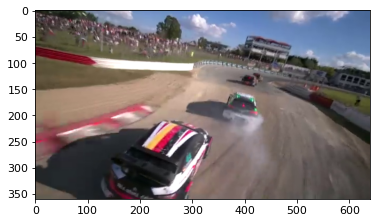

In [ ]:
col_list = ['frame', 'object', 'xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class', 'name']
results_df = pd.DataFrame(columns=col_list)


for i in range(1000):
    ret, frame = cap.read()
    if i%100==0:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = model(frame)

        for j in range(results.xyxyn[0].shape[0]):
            data_to_append = {}
            for k in range(len(col_list)):
                print(results_df.columns[i])
                if k==0:
                    val = frame_num
                elif k==1:
                    val = object_num
                else:
                    val = results.xyxyn[0][0][i-2]

                data_to_append[col_list[i]] = val

            results_df = results_df.append(data_to_append, ignore_index = True)

        results_df = results_df.append({'frame':0, 'object':1}, ignore_index=True)
        results_df[col_list[2:]] = results.pandas().xyxyn[0]
        results_df

frame = frames[7].copy()
plt.imshow(frame)
plt.show()

In [ ]:
# results = model(frame)
df = results.pandas().xyxy[0] 
df

,xmin,ymin,xmax,ymax,confidence,class,name
0,88.571320,97.946022,315.719177,272.055511,0.925316,2,car
1,338.391449,87.637817,525.419800,179.169495,0.916659,2,car
2,291.779694,70.021332,382.510712,112.968979,0.876787,2,car


In [ ]:
df.to_json('res.json', orient="index", indent=4) 

In [ ]:
results = model2(frame)

NameError: ignored

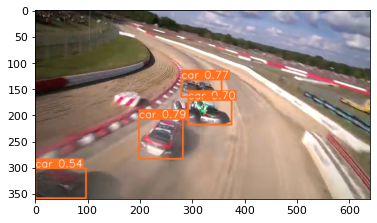

In [ ]:
results.ims[0].shape
plt.imshow(results.ims[0])
plt.show()

In [ ]:
col_list = ['frame', 'object', 'xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class', 'name']
results_df = pd.DataFrame(columns=col_list)
results_df

,frame,object,xmin,ymin,xmax,ymax,confidence,class,name


In [ ]:
col_list = ['frame', 'object', 'xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class', 'name']
results_df = pd.DataFrame(columns=col_list)

results_df = results_df.append({'frame':0, 'object':1}, ignore_index=True)
results_df[col_list[2:]] = results.pandas().xyxyn[0]
results_df

,frame,object,xmin,ymin,xmax,ymax,confidence,class,name
0,0.0,1.0,0.138393,0.272072,0.493311,0.75571,0.925316,2,car


In [ ]:
results.print()

image 1/1: 360x640 3 cars
Speed: 5.4ms pre-process, 1335.0ms inference, 1.8ms NMS per image at shape (1, 3, 384, 640)


In [ ]:
results_df

,frame,object,xmin,ymin,xmax,ymax,confidence,class,name
0,0.0,1.0,0.362500,0.482772,0.459106,0.618716,0.812211,2.0,car
1,0.0,1.0,0.504821,0.657286,0.602488,0.917860,0.804977,2.0,car
2,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
col_list[2:]

['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class', 'name']

In [ ]:
results_df[col_list[2:]] = results.pandas().xyxyn[0]

In [ ]:
results.pandas().xyxyn[0]

,xmin,ymin,xmax,ymax,confidence,class,name
0,0.362500,0.482772,0.459106,0.618716,0.812211,2,car
1,0.504821,0.657286,0.602488,0.917860,0.804977,2,car


In [ ]:
# results.pandas().xyxy[0].to_json(orient="records") 
result = results.pandas().xyxyn[0].to_json('res.json', orient="index", indent=4) 
results.pandas().xyxy[0].to_json('res.json', orient="index") 
result

'{\n    "0":{\n        "xmin":253.749786377,\n        "ymin":149.9034118652,\n        "xmax":330.0815124512,\n        "ymax":196.5151062012,\n        "confidence":0.7756231427,\n        "class":2,\n        "name":"car"\n    },\n    "1":{\n        "xmin":323.895324707,\n        "ymin":139.7468109131,\n        "xmax":363.7653198242,\n        "ymax":175.2721099854,\n        "confidence":0.5865973234,\n        "class":2,\n        "name":"car"\n    }\n}'

In [ ]:
# result = df.to_json(orient="split")
parsed = json.loads(result)
json.dumps(parsed, indent=4) 

'{\n    "0": {\n        "xmin": 253.749786377,\n        "ymin": 149.9034118652,\n        "xmax": 330.0815124512,\n        "ymax": 196.5151062012,\n        "confidence": 0.7756231427,\n        "class": 2,\n        "name": "car"\n    },\n    "1": {\n        "xmin": 323.895324707,\n        "ymin": 139.7468109131,\n        "xmax": 363.7653198242,\n        "ymax": 175.2721099854,\n        "confidence": 0.5865973234,\n        "class": 2,\n        "name": "car"\n    }\n}'

In [ ]:
res_img = results.render()

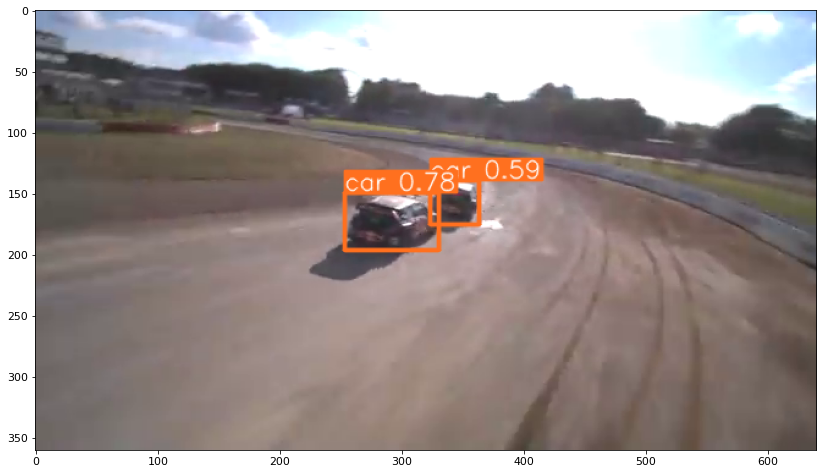

In [ ]:
fig = plt.figure(figsize=(14, 10))

plt.imshow(np.squeeze(res_img))
plt.show()

In [ ]:
results.xyxy[0]

tensor([], size=(0, 6))

In [ ]:
line = results.xyxy[0].numpy()[0]
boxes = line[:4]
score = line[4]
class_id = line[5]

array([      286.3,      105.26,      385.79,       186.9,     0.76422,           2], dtype=float32)

In [ ]:
image_with_boxes = draw_results(frame, results)

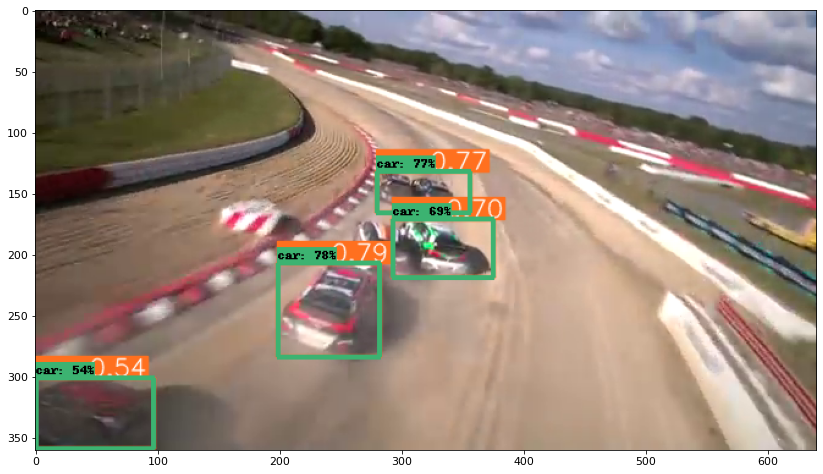

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(image_with_boxes)
plt.show()

In [ ]:
frame.shape

(360, 640, 3)

In [ ]:
HEIGHT = 224
WIDTH = 224

input_frame = cv2.resize(frame, (HEIGHT, WIDTH), cv2.INTER_AREA)
input_frame = input_frame[np.newaxis,:,:,:]

input_tensor = tf.convert_to_tensor(input_frame) #, dtype=tf.float32)
input_tensor.shape

TensorShape([1, 224, 224, 3])

In [ ]:
detector = hub.load("https://tfhub.dev/tensorflow/efficientdet/d0/1")

In [ ]:

detector_output = detector(input_tensor)
num_detections = detector_output["num_detections"].numpy()
detection_boxes = detector_output["detection_boxes"].numpy()[0]
detection_scores = detector_output["detection_scores"].numpy()[0]
class_ids = detector_output["detection_classes"].numpy()[0]

In [ ]:
threshold = 0.4
ind = np.where(detection_scores > threshold)
ind = np.squeeze(ind)
print(f"Total {len(ind)} objects found with confidence > {threshold}")

Total 5 objects found with confidence > 0.4


In [ ]:
class_names = {3:'Vehicle'}

In [ ]:
class_ids = class_ids[ind].astype('uint8')
ind = np.where(class_ids == 3)
ind = np.squeeze(ind)
print(f"Total {len(ind)} Cars found")

detection_boxes = detection_boxes[ind]
detection_scores = detection_scores[ind]

Total 5 Cars found


In [ ]:
class_ids , detection_scores


(array([3, 3, 3, 3, 3], dtype=uint8),
 array([0.71161336, 0.69188917, 0.517278  , 0.4772195 , 0.44686887],
       dtype=float32))

In [ ]:
class_names[3]

'Vehicle'

In [ ]:
detection_scores

array([0.71161336, 0.69188917, 0.517278  , 0.4772195 , 0.44686887],
      dtype=float32)

In [ ]:
image_with_boxes = draw_boxes(
    frame, detection_boxes,
    class_ids, detection_scores)

In [ ]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())
  new_image = image.copy()
  font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format('Vehicle',
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(new_image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(new_image, np.array(image_pil))
  return new_image

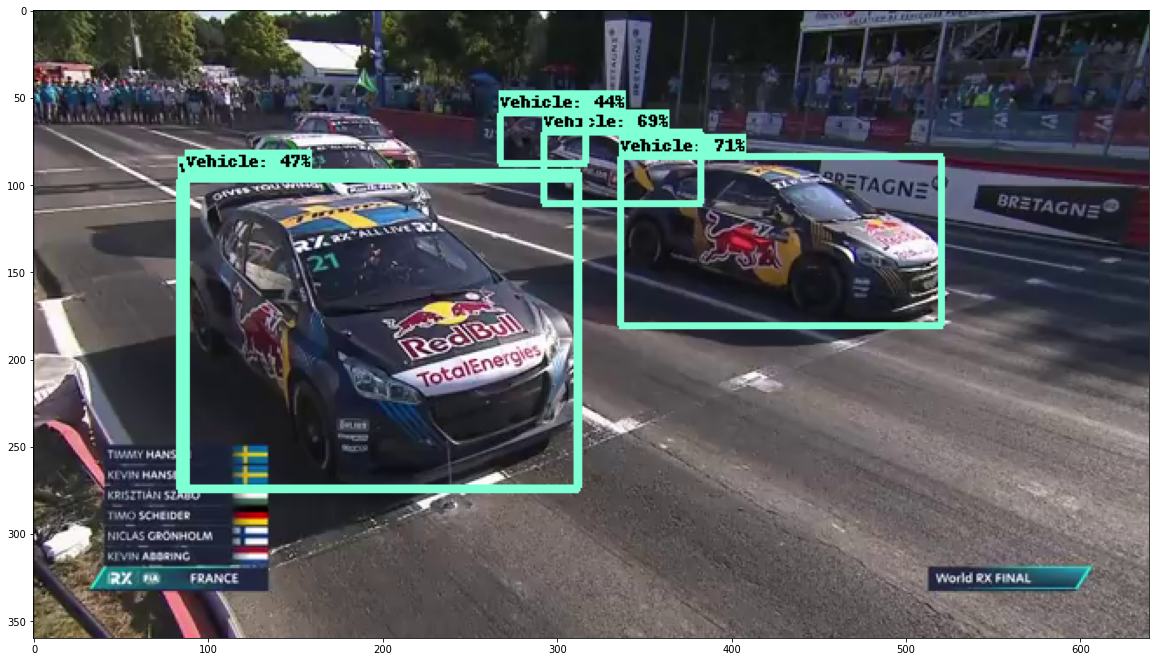

In [ ]:
fig = plt.figure(figsize=(20, 15))
plt.imshow(image_with_boxes)
plt.show()

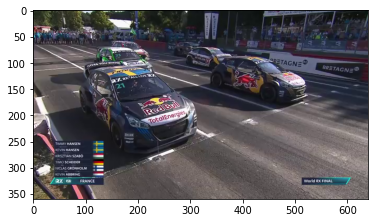

In [ ]:
plt.imshow(frame)
plt.show()